**Train a CNN in Pytorch to classify spoken digits (0 - 9)**

See Github repo here: https://github.com/winstonwzhang/spoken_digit_classify

First we install the necessary libraries and download the dataset of audio clips: https://github.com/Jakobovski/free-spoken-digit-dataset

In [0]:
# get CPU and GPU info
! nvidia-smi
! nproc --all

Sun Sep 15 18:34:36 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.40       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8    27W / 149W |      0MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
# install pytorch and torchaudio
! pip install torchaudio

     |████████████████████████████████| 2.6MB 6.4MB/s 
     |████████████████████████████████| 748.9MB 18kB/s 
  Found existing installation: torch 1.1.0
    Uninstalling torch-1.1.0:
      Successfully uninstalled torch-1.1.0


In [0]:
# plot inline
%matplotlib inline

In [0]:
# get training data
! git clone https://github.com/Jakobovski/free-spoken-digit-dataset

Cloning into 'free-spoken-digit-dataset'...
remote: Enumerating objects: 3157, done.
remote: Total 3157 (delta 0), reused 0 (delta 0), pack-reused 3157
Receiving objects: 100% (3157/3157), 23.91 MiB | 16.85 MiB/s, done.
Resolving deltas: 100% (69/69), done.


In [0]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

Next we start defining the hyperparameters necessary for data preprocessing:

In [0]:
import os
import math
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import librosa
import librosa.display
import librosa.effects
import torch
import torchaudio
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

In [0]:
# default data hyperparameters
class conf:
    sr = 8000  # sampling rate
    duration = 2.3  # how long input samples are in seconds
    hop_length = int(sr * 0.0115)  # step size half of frame
    fmin = 0.0
    fmax = 22050.0  # freq range of human speech
    n_mels = 25  # number of mfcc coefficients
    n_fft = int(sr * 0.023)  # frames of 0.023 sec
    padmode = 'constant'
    samples = sr * duration  # length of input samples in array size
    aug_probs = {'noise': 0.7,
                 'pitch': 0.3,
                 'speed': 0.7,
                 'shift': 0.8}  # prob of augment being applied

We want to use some simple audio augmentations to increase the effective size of our training set. Here the data augmentation class has noise addition, pitch shift, and time shift augmentations, implemented using the librosa library.


Each augmentation has a certain probability of being applied to an audio clip that is specified in the hyperparameter dict "aug_probs".

In [0]:
class Transform:
    '''Audio data augmentation class.'''
    def __init__(self, conf, wav):
        self.wav = wav
        self.conf = conf
    
    def run_transforms(self):
        x = self.wav
        if random.uniform(0, 1) < self.conf.aug_probs['pitch']:
            x = self.pitch_shift(x)
        if random.uniform(0, 1) < self.conf.aug_probs['speed']:
            x = self.speed_change(x)
        return x
    
    def add_noise(self, wav):
        if random.uniform(0, 1) < self.conf.aug_probs['noise']:
            noise = np.random.normal(size=len(wav))
            factor = 0.005 * random.uniform(0, 1) * max(wav)
            return wav + factor * noise
        else:
            return wav
    
    def pitch_shift(self, wav):
        pitch_pm = 2
        pitch_change = pitch_pm * 2 * random.uniform(0, 1)
        return librosa.effects.pitch_shift(
            wav, self.conf.sr, n_steps=pitch_change)
    
    def speed_change(self, wav):
        factor = np.random.normal(1, 0.2, 1)
        tmp = librosa.effects.time_stretch(wav, factor)
        minlen = min(wav.shape[0], tmp.shape[0])
        wav += 0
        wav[0:minlen] = tmp[0:minlen]
        return wav

Inputs to the CNN must be constant, so clips shorter than the length we decided (2.3 seconds) must be padded with zeros to be consistent.

Here is another chance for data augmentation - we vary the amount of zeros padded on both sides, so the section of audio that contains the spoken digit will be shifted left and right randomly. This way, the CNN will not only see inputs with speech centered in the middle of the entire 2.3 seconds.

In [0]:
def pad_audio(conf, audio, transform):
    # pad or cut audio to same length as conf.samples
    if len(audio) > conf.samples:
        audio = audio[0:0+conf.samples]
    elif len(audio) < conf.samples: # pad blank
        padding = conf.samples - len(audio)    # add padding at both ends
        if transform and random.uniform(0, 1) < conf.aug_probs['shift']:
            offset = random.randint(0, padding)
        else:
            offset = math.ceil(padding // 2)
        # random shift of audio (speech not always in center of spectrogram)
        padwidth = (offset, math.ceil(padding - offset))
        audio = np.pad(audio, padwidth, conf.padmode)
    return audio

Some functions for extracting and visualizing the Mel-Frequency Cepstrum Coefficients (MFCCs) that we will be using as feature inputs to the CNN.

These speech features are commonly used in the speech analysis field. They capture sound characteristics on frequencies familiar to the human ear. Detailed explanation: http://practicalcryptography.com/miscellaneous/machine-learning/guide-mel-frequency-cepstral-coefficients-mfccs/

In [0]:
def audio_to_mfcc(conf, audio):
    spectrogram = librosa.feature.mfcc(audio, 
                                       sr=conf.sr,
                                       n_mfcc=conf.n_mels,
                                       hop_length=conf.hop_length,
                                       n_fft=conf.n_fft,
                                       fmin=conf.fmin,
                                       fmax=conf.fmax)
    spectrogram = spectrogram.astype(np.float32)
    return spectrogram

def show_mfcc(conf, mels, title='MFCC'):
    librosa.display.specshow(mels,
                             x_axis='time',
                             sr=conf.sr,
                             hop_length=conf.hop_length)
    plt.colorbar(format='%+2.0f dB')
    plt.title(title)
    plt.tight_layout()
    plt.show()

Now let's put everything together! This function will:
- load the .wav audio file
- apply data augmentations to the raw audio
- pad with zeros
- add gaussian noise
- convert the augmented result into MFCCs.

In [0]:
def read_as_mfcc(conf, pathname, transform):
  
    # librosa slow to load on Colab for some reason
    x, _ = torchaudio.load(pathname)
    x = x[0, :].detach().numpy()
    
    # apply audio data augmentations (pitch, speed)
    if transform:
        tr = Transform(conf, x)
        x = tr.run_transforms()
        
    # padding for uniform input length
    x = pad_audio(conf, x, transform)
    
    # add noise to simulate realistic conditions
    if transform:
        x = tr.add_noise(x)
        
    # get mfccs
    mfcc = audio_to_mfcc(conf, x)
    
    # show_mfcc(conf, mfcc)
    return mfcc

Here we define the Pytorch Dataset class that will apply the above transformations to every .wav file that the CNN wants to use.

The resultant MFCC features are also normalized to center around zero within each individual coefficient before being sent to the network. This can reduce the variation between recording conditions between different .wav files.

In [0]:
class Digit_Dataset(Dataset):
    '''Dataset class that pads and converts a sample into mfcc.'''
    def __init__(self, wav_dir, transform=True):
        self.wav_dir = wav_dir
        self.data = os.listdir(wav_dir)
        # keep only .wav files
        self.data = [s for s in self.data if '.wav' in s]
        self.labels = [int(s[0]) for s in self.data]
        self.transform = transform
          
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        with torch.no_grad():
            wav_name = self.data[idx]
            label = self.labels[idx]

            mfcc_data = read_as_mfcc(
                conf, self.wav_dir + wav_name, self.transform)
            
            # normalize mfcc coefficients within each sample
            mfcc_mean = np.mean(mfcc_data, axis=1)
            mfcc_std = np.std(mfcc_data, axis=1)
            
            # broadcast across all time frames
            mfcc_mean = mfcc_mean[:, np.newaxis]
            mfcc_std = mfcc_std[:, np.newaxis]
            mfcc_data = (mfcc_data - mfcc_mean) / mfcc_std
            
            img = torch.from_numpy(mfcc_data)
            img = img.unsqueeze_(0) # add singleton dimension

            sample = {'img': img, 'label': label}

            return sample
    
    def visualize_labels(self, transform=True):
        for i in range(4):
            idx = self.labels.index(i)
            mfcc = read_as_mfcc(conf, self.wav_dir + self.data[idx], transform)
            plt.subplot(2, 2, i+1)
            librosa.display.specshow(mfcc,
                                     x_axis='time',
                                     sr=conf.sr,
                                     hop_length=conf.hop_length)
            plt.colorbar(format='%+2.0f dB')
            plt.title(str(i))
        plt.tight_layout()
        plt.show()

Let's visualize the input MFCC features! We will compare MFCCs that have been augmented, and MFCCs that are directly extracted from original audio.

Our validation inputs will not have data augmentation, since we want an unbiased estimate of our model's performance on the original data.

The MFCC feature maps are 25 by 200 in size.

25 - number of MFCCs extracted per frame

200 - number of 0.023 second frames within 2.3 seconds (frame hop is 0.0115 seconds, so a total of 200 frames)

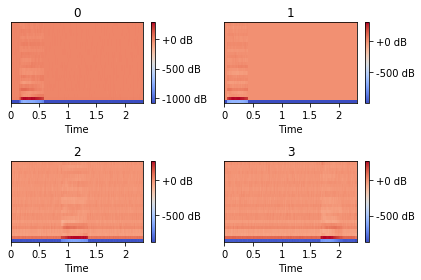

In [0]:
wav_dir = 'free-spoken-digit-dataset/recordings/'

train_db = Digit_Dataset(wav_dir, transform=True)
val_db = Digit_Dataset(wav_dir, transform=False)

train_db.visualize_labels(transform=True)

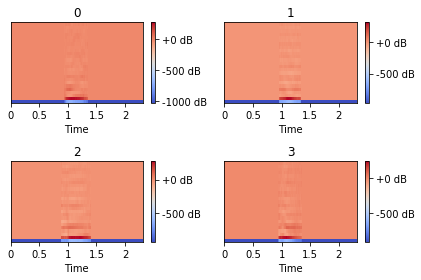

In [0]:
val_db.visualize_labels(transform=False)

Our data preprocessing is done! Now we define the model architecture:

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np


class BaseModel(nn.Module):
  '''Main neural net model.'''
  def __init__(self):
    super(BaseModel, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=24, kernel_size=3)
    self.bn1 = nn.BatchNorm2d(24)
    self.pool1 = nn.MaxPool2d(kernel_size=(1, 2))
    
    self.conv2 = nn.Conv2d(in_channels=24, out_channels=48, kernel_size=3)
    self.conv2o = nn.Conv2d(in_channels=48, out_channels=24, kernel_size=1)
    self.bn2 = nn.BatchNorm2d(24)
    self.pool2 = nn.MaxPool2d(kernel_size=(1, 2))
    
    self.conv3 = nn.Conv2d(in_channels=24, out_channels=48, kernel_size=3)
    self.conv3o = nn.Conv2d(in_channels=48, out_channels=24, kernel_size=1)
    self.bn3 = nn.BatchNorm2d(24)
    self.pool3 = nn.MaxPool2d(kernel_size=(2, 2))
    
    self.drop1 = nn.Dropout(p=0.2)
    self.fc1 = nn.Linear(in_features=4968, out_features=1024)
    self.drop2 = nn.Dropout(p=0.2)
    self.fc2 = nn.Linear(in_features=1024, out_features=64)
    self.fc3 = nn.Linear(in_features=64, out_features=10)

  def forward(self, x):
    
    x = F.relu(self.conv1(x))
    x = self.pool1(self.bn1(x))
    
    x = F.relu(self.conv2(x))
    x = F.relu(self.conv2o(x))
    x = self.pool2(self.bn2(x))
    
    x = F.relu(self.conv3(x))
    x = F.relu(self.conv3o(x))
    x = self.pool3(self.bn3(x))
    
    x = torch.flatten(x, start_dim=1)
    
    x = self.drop1(x)
    x = F.relu(self.fc1(x))
    
    x = self.drop2(x)
    x = F.relu(self.fc2(x))
    
    x = self.fc3(x)
    return x

I decided on three convolutional layers and three fully connected layers, with batch norm and max pooling between conv layers and dropout between the linear layers.

The input images are small in dimension, so I used 3x3 convolutions to capture the small variations in MFCC channels.

I used 1x2 max pooling since our y-axis dimension is only 25 - too much pooling, and a lot of information would be lost!

I also used 1x1 convolutions to reduce the number of channels between successive layers. This helps reduce the number of parameters that needs to be learned, and also prevents the fully connected layers from having hundreds of thousands of parameters! It can help make the network light-weight and easier to train.

This technique has been widely used in recent models for managing the large number of parameters that will result from convolution layers.

In [0]:
import torch.utils.data
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SubsetRandomSampler

Let's begin the training process by defining more hyperparameters:

In [0]:
########### Hyper-parameters #####################
class hp:
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    lr = 3e-4  # learning rate
    num_epochs = 50
    batch_size = 50
    validation_split = .2
    shuffle_dataset = True
    random_seed = 42
    num_w = 8  # number of parallel workers
    weight_decay = 1e-3

print(hp.device)

save_path = 'fsdd_cnn_sdict.pt'

cuda:0


We divide the dataset randomly into three parts: train, validation, and test.

Training contains 80% of data, validation 10%, and testing 10%. 

Validation set is used for evaluating which training epoch performed the best and to check for overfitting or underfitting. Because of this, validation set cannot be used for final test results, as that would possibly result in data leakage.

In [0]:
dataset_size = len(train_db.labels)
indices = list(range(dataset_size))
split = int(np.floor(hp.validation_split * dataset_size))

if hp.shuffle_dataset :
    np.random.seed(hp.random_seed)
    np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]
test_indices = val_indices[:len(val_indices) // 2]
val_indices = val_indices[len(val_indices) // 2:]  # split into val and test

num_train = len(train_indices)
num_val = len(val_indices)
num_test = len(test_indices)

# Creating data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)
test_sampler = SubsetRandomSampler(test_indices)

train_dataloader = DataLoader(train_db, batch_size=hp.batch_size, 
                              sampler=train_sampler, num_workers=hp.num_w)
val_dataloader = DataLoader(val_db, batch_size=hp.batch_size,
                            sampler=valid_sampler, num_workers=hp.num_w)
test_dataloader = DataLoader(val_db, batch_size=hp.batch_size,
                            sampler=test_sampler, num_workers=hp.num_w)

Define the training and validation functions. We will use Cross Entropy loss function for this multiclass classification problem, and Adam learning rate optimizer.



In [0]:
############## Initialize Weights #######################
def init_weights(m):
    if type(m) == nn.Linear or type(m) == nn.Conv2d:
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0.01)


############## Main Function #######################
def run():
    model = BaseModel().double() # Creating the model
    model.apply(init_weights)

    model = model.to(hp.device)

    criterion = nn.CrossEntropyLoss().to(hp.device)
    optimizer = torch.optim.Adam(model.parameters(),
                                 lr=hp.lr,
                                 weight_decay=hp.weight_decay)
        
    # train!
    result = train(model, criterion, optimizer)
    print(result)
    # test
    print('Testing starts !!!')
    test_acc, test_loss = val(model, criterion, test_dataloader)
    print('test_acc:{}, test_loss:{}'.format(test_acc, test_loss))


############ Validation function #############
def val(model, criterion, dl):
    with torch.no_grad():
      
        print('Validation starts !!!')
        
        running_corrects = 0
        loss_sum = 0.0
        
        for it, data in enumerate(dl):
            #if it % 10 == 0:
            #    print(it)
            inp = data['img']
            target = data['label']

            inp = inp.double().to(hp.device)
            target = target.to(hp.device)
            model = model.to(hp.device)

            # ===================forward=====================
            output = model(inp)
            loss = criterion(output, target)
            loss_sum += loss.item()
            _, preds = torch.max(output, 1)
            running_corrects += (preds == target.data).sum().cpu().numpy()

        acc = running_corrects / num_val
        loss_sum = loss_sum / len(dl)
        print('Accuracy:{0}, Loss:{1}'.format(acc, loss_sum))
        return acc, loss_sum


############ Training function ###################
def train(model, criterion, optimizer):
    print('Initial validation:')
    val(model, criterion, val_dataloader)

    print('Training starts !!!')
    tr_losses=[]
    tr_accs = []
    val_losses=[]
    val_accs = []
    best_epoch = 0
    best_acc = 0.0
    
    for epoch in range(hp.num_epochs):
        start = time.time()
        
        model.train()  # train mode

        running_corrects = 0
        loss_sum = 0.0

        for it,data in enumerate(train_dataloader):
            #if it % 10 == 0:
            #  print(it)
            inp = data['img']
            target = data['label']

            inp = inp.double().to(hp.device)
            target = target.to(hp.device)
            model = model.to(hp.device)
            # ===================forward=====================
            output = model(inp)
            loss = criterion(output, target)
            loss_sum += loss.item()
            _, preds = torch.max(output, 1)
            running_corrects += (preds == target.data).sum().cpu().numpy()
            # ===================backward====================
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        model.eval()  # eval mode
        
        duration = time.time() - start
        loss_sum = loss_sum / len(train_dataloader)
        tr_acc = running_corrects / num_train
        print('epoch [{}/{}], Tr loss:{:.4f} Tr Acc:{:.4f} Time:{:.4f}'.format(
            epoch+1, hp.num_epochs, loss_sum, tr_acc, duration))
        tr_losses.append(loss_sum)
        tr_accs.append(tr_acc)

        val_acc, val_loss = val(model, criterion, val_dataloader)
        val_accs.append(val_acc)
        val_losses.append(val_loss)
    
        if val_acc > best_acc:
            best_acc = val_acc
            best_epoch = epoch + 1
            # save model
            torch.save(model.state_dict(), save_path)
    
    # save accs and loss
    np.save('tr_accs.npy', np.array(tr_accs))
    np.save('val_accs.npy', np.array(val_accs))
    np.save('train_losses.npy', np.array(tr_losses))
    np.save('val_losses.npy', np.array(val_losses))
    
    return {'best_epoch': best_epoch, 'best_acc': best_acc}

Time to train!

In [0]:
run()

Initial validation:
Validation starts !!!
Accuracy:0.065, Loss:4.6204608105015685
Training starts !!!
epoch [1/50], Tr loss:2.6016 Tr Acc:0.1281 Time:30.6067
Validation starts !!!
Accuracy:0.235, Loss:2.188315671540967
epoch [2/50], Tr loss:2.3096 Tr Acc:0.1138 Time:29.7878
Validation starts !!!
Accuracy:0.225, Loss:2.179539379763033
epoch [3/50], Tr loss:2.2843 Tr Acc:0.1319 Time:30.1319
Validation starts !!!
Accuracy:0.255, Loss:2.005047729328915
epoch [4/50], Tr loss:2.2170 Tr Acc:0.1650 Time:30.0012
Validation starts !!!
Accuracy:0.25, Loss:1.9689487411991684
epoch [5/50], Tr loss:2.0692 Tr Acc:0.2288 Time:30.9642
Validation starts !!!
Accuracy:0.375, Loss:1.6418249030927017
epoch [6/50], Tr loss:1.8398 Tr Acc:0.3019 Time:30.0076
Validation starts !!!
Accuracy:0.555, Loss:1.2227676897036441
epoch [7/50], Tr loss:1.5859 Tr Acc:0.4169 Time:30.2237
Validation starts !!!
Accuracy:0.68, Loss:1.0065501093486888
epoch [8/50], Tr loss:1.3987 Tr Acc:0.4662 Time:30.5294
Validation starts !!!

Plot loss and accuracy curves:

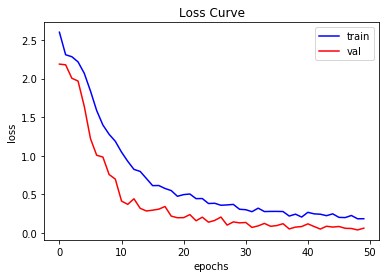

In [0]:
import matplotlib.pyplot as plt

plt.clf()

train_losses = np.load('train_losses.npy')
val_losses = np.load('val_losses.npy')

plt.plot(np.arange(hp.num_epochs), train_losses, 'b', label='train')
plt.plot(np.arange(hp.num_epochs), val_losses, 'r', label='val')
plt.title('Loss Curve')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

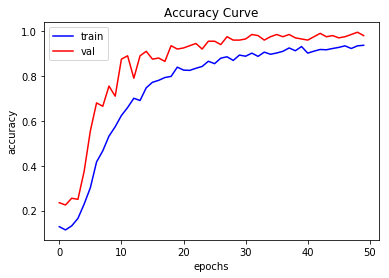

In [0]:
plt.clf()

tr_accs = np.load('tr_accs.npy')
val_accs = np.load('val_accs.npy')

plt.plot(np.arange(hp.num_epochs), tr_accs, 'b', label='train')
plt.plot(np.arange(hp.num_epochs), val_accs, 'r', label='val')
plt.title('Accuracy Curve')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

The training curve always performs slightly worse than validation, mostly because of the heavily augmented data we input to training. This is fine, since it signifies our model hasn't overfit.

**What's Next?**

- Train network using larger number of speakers and samples like in this Kaggle competition: https://www.kaggle.com/c/tensorflow-speech-recognition-challenge
- Apply trained model to predict speech in real time using PyAudio. Check out "demo.py" in my Github repository: https://github.com/winstonwzhang/spoken_digit_classify/blob/master/demo.py
- Add noise removal and a filtering algorithm so that only clips of speech will be input for the model to classify in real time. A possibility is training an SVM to classify if a clip of sound "looks" like speech or not.

Thanks for checking out my demo! Please email me at wwzhang@umich.edu if you have any questions, concerns, or complaints - especially if I did or wrote something wrong in the training process. I always want to learn from my mistakes!